<a href="https://colab.research.google.com/github/jecampagne/JaxTutos/blob/main/JAX_Cophy_tuto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1500,
        'height': 768,
        'scroll': True,
})

from IPython.display import HTML
HTML('''<style>.CodeMirror{min-width:100% !important;}</style>''')


In [2]:
%%HTML
<!-- reveal.js CSS theme and local overrides -->
<link rel="stylesheet" href="presentation.css"/>

<center>  <h1>GDR Cophy JAX Tutorial: a starter </h1>
<br>
 <div align="center">  J.E Campagne (IJCLab) </div>
 <div align="center">  Nov 2024  </div>
    

# Theme: get some first flavour of JAX


I will not go into multi-devices CPU or GPU, see Wassim Kabalan's talk.
Also all the code below is running smoothly on a single CPU, i.e no need of GPU. 
You can test it on Google Colab TPU.

This Tuto is "rather" short, so do not expect an exhaustive shoping list of how-to.
1. See https://jax.readthedocs.io/en/latest/index.html
2. You can find same more material [here on my repo](https://github.com/jecampagne/JaxTutos)

Google starts deveopping JAX in 2018 for machine learning framework. Notice that `Gemini` is written in JAX. The library development is very active.

JAX is one of the backend of `TensorFlow` and `Keras`.

JAX Ecosystem is already quite large:
- Have a look at  
    - [awesome-jax](https://project-awesome.org/n2cholas/awesome-jax)
    - [jaxopt](https://jaxopt.github.io): differentiable optimizers...
    - [optax](https://optax.readthedocs.io): gradient processing and optimization library.
    - [BlackJAX](https://blackjax-devs.github.io/blackjax/): samplers...
    - [Numpyro](https://num.pyro.ai):  Probability Programming Language.
    - [FLAX](https://flax.readthedocs.io), [Haiku](https://dm-haiku.readthedocs.io): Neural Net libraries.
    -...
- More Cosmology-centred:
   - [JaxPM](https://github.com/DifferentiableUniverseInitiative/JaxPM): JAX-powered Cosmological Particle-Mesh N-body Solver
   - [S2FFT](http://www.jasonmcewen.org/project/s2fft/): JAX package for computing Fourier transforms on the sphere and rotation group
   - [JAX-Cosmo](https://github.com/DifferentiableUniverseInitiative/jax_cosmo): a differentiable cosmology library in JAX
   - [JAX-GalSim](https://github.com/GalSim-developers/JAX-GalSim): JAX version *in development* of the C++ Galsim code (GalSim is open-source software for simulating images of astronomical objects (stars, galaxies) in a variety of ways)
   - [CosmoPower-JAX](https://github.com/dpiras/cosmopower-jax): example of cosmological power spectra emulator in a differentiable way
   - [DISCO-EB](https://github.com/ohahn/DISCO-EB): a differentiable Einstein-Boltzmann solver for cosmology ([here](https://arxiv.org/abs/2311.03291))
   - and your favorite code (sorry my list is absolutly non-exhausitive).

In [3]:
import jax

import jax.numpy as jnp
import numpy as np

from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian
jax.config.update("jax_enable_x64", True)     # by default float32

from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18

print(jax.__version__)  #<=0.4.33 (September 16, 2024)
print(jax.devices())

0.4.33
[CpuDevice(id=0)]


In [4]:
def MatplotlibClearMemory():
    allfignums = mpl.pyplot.get_fignums()
    for i in allfignums:
        fig = mpl.pyplot.figure(i)
        fig.clear()
        mpl.pyplot.close( fig )

One remark concerns the import: there is (at least) 2 ways of naming that you can see in libraries:
-    either (numpy -> np, jax.numpy -> jnp)
-    or (numpy -> onp, jax.numpy -> np)
So, when you edit or C&P a JAX code have a look at import to figure out which convention has been adopted by the author(s).

There is also a `jax.scipy` module but this is not the complete library API.

# JAX Numpy very close to Numpy


In [20]:
x = np.arange(0.,10.,1)
x

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [21]:
# Numpy Array -> JAX
jx = jnp.array(x)
jx, type(jx)

(Array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float64),
 jaxlib.xla_extension.ArrayImpl)

In [22]:
# JAX Array -> Numpy
y = np.asarray(jx)
y, type(y)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), numpy.ndarray)

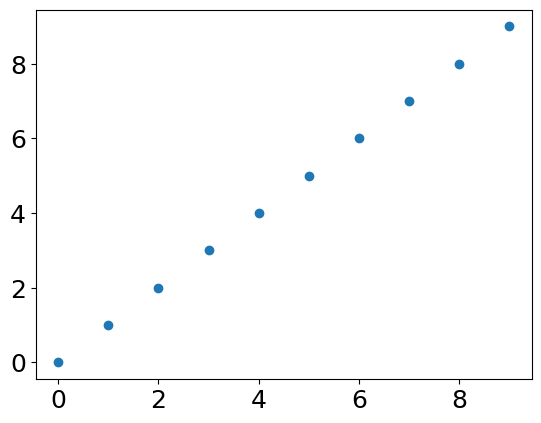

In [23]:
plt.scatter(x, jx); # no need to convert jnp.array to numpy array here

## JAX Array are immutable

In [24]:
jx = jnp.arange(0.,10.,1) # notice np->jnp
jx[2]=-1

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [25]:
jx = jx.at[2].set(-1) # other functions jax.numpy.ndarray.at exist: slicing, add....
jx

Array([ 0.,  1., -1.,  3.,  4.,  5.,  6.,  7.,  8.,  9.], dtype=float64)

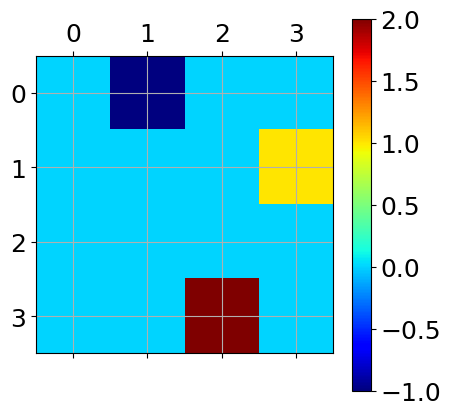

In [10]:
ldx = jnp.array([0,1,3]) # "l" line indexes
cdx = jnp.array([1,3,2]) # "c" column indexes
val = jnp.array([-1,1,2])# values V_{lc}
mtx = jnp.zeros((4,4)).at[ldx,cdx].set(val)   #<------
plt.matshow(mtx);plt.colorbar();
plt.grid()

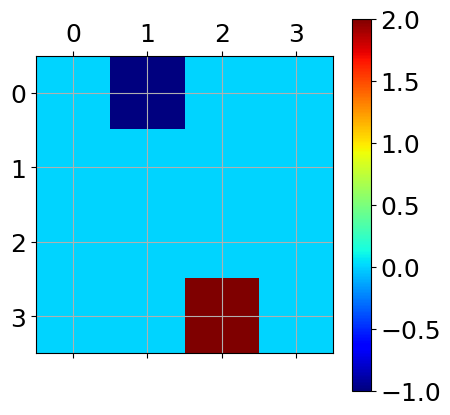

In [11]:
ldx = jnp.array([0,1,3,1])
cdx = jnp.array([1,3,2,3])
val = jnp.array([-1,1,2,-1])
mtx = jnp.zeros((4,4)).at[ldx,cdx].add(val)   #<----- add all V_{lc} in the same (l,c)
plt.matshow(mtx);plt.colorbar();
plt.grid()

# Automatic differentiation and vectorization

In [10]:
def f(x):
    return jnp.exp(-x*0.5)*jnp.sin(x)

# Exact f'(x) et f''(x)
def fp(x):
    return jnp.exp(-x*0.5)*(2.*jnp.cos(x)-jnp.sin(x))/2.
def fpp(x):
    return -jnp.exp(-x*0.5)*(4.*jnp.cos(x)+3.*jnp.sin(x))/4.

# Numerical differenciation via central finite differences  f'(x) et f''(x)
def fpnum(x,h=0.1):
    return (f(x+h)-f(x-h))/(2*h)
def fppnum(x,h=0.1):
    return (f(x+h)-2*f(x)+f(x-h))/h**2

In [11]:
# With JAX gradient (grad)
jfp  = grad(f)            #f'
jfpp = grad(grad(f))      #f''

Code inspection: take a paper and a pencil and check that this code is correct :)

In [12]:
jax.make_jaxpr(f)(0.)

{ lambda ; a:f64[]. let
    b:f64[] = neg a
    c:f64[] = mul b 0.5
    d:f64[] = exp c
    e:f64[] = sin a
    f:f64[] = mul d e
  in (f,) }

In [13]:
jax.make_jaxpr(jfp)(0.)

{ lambda ; a:f64[]. let
    b:f64[] = neg a
    c:f64[] = mul b 0.5
    d:f64[] = exp c
    e:f64[] = sin a
    f:f64[] = cos a
    _:f64[] = mul d e
    g:f64[] = mul d 1.0
    h:f64[] = mul 1.0 e
    i:f64[] = mul g f
    j:f64[] = mul h d
    k:f64[] = mul j 0.5
    l:f64[] = neg k
    m:f64[] = add_any i l
  in (m,) }

## Vectorization
`vmap` is for instance used when we call a function with an array. The result is not like numpy vectorize which is a for-loop.  
Notice that usual math functions are by default "vectorized"

In [14]:
jfp  = vmap(grad(f))
jfpp = vmap(grad(grad(f)))

## Let us make a plot

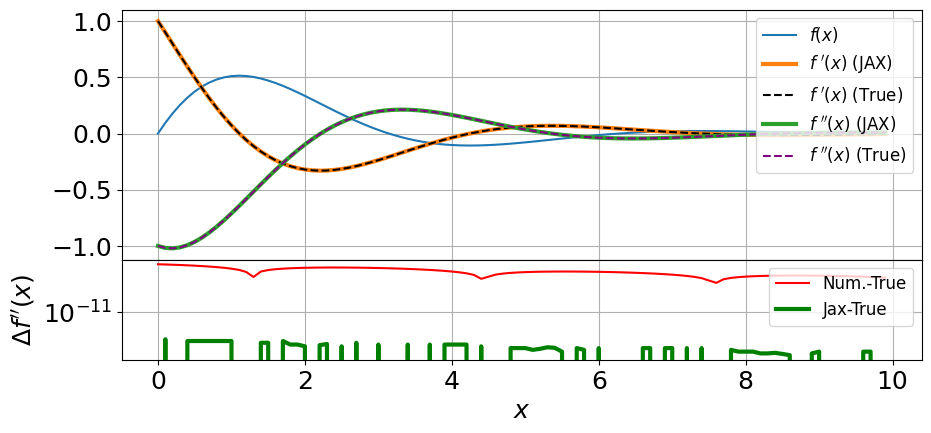

In [15]:
x=jnp.arange(0,10,0.1)

fig1 = plt.figure(1, figsize=(10,5))
frame1=fig1.add_axes((.1,.30,.8,.5))

plt.plot(x,f(x), label="$f(x)$")
plt.plot(x,jfp(x), lw=3,label="$f^{\ \prime}(x)$ (JAX)")
plt.plot(x,fp(x),ls="--",c='k', label="$f^{\ \prime}(x)$ (True)")
plt.plot(x,jfpp(x), lw=3,label="$f^{\ \prime\prime}(x)$ (JAX)")
plt.plot(x,fpp(x),ls="--", c='purple',label="$f^{\ \prime\prime}(x)$ (True)")
plt.grid()
plt.xlabel("$x$")
plt.legend(loc="upper right",fontsize=12);

frame1.set_xticklabels([])

frame2=fig1.add_axes((.1,.1,.8,.2))
plt.plot(x,np.abs(fppnum(x)-fpp(x)), c="r", label="Num.-True")
plt.plot(x,np.abs(jfpp(x)-fpp(x)),lw=3,c="g",  label="Jax-True")
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$\Delta f^{\prime\prime}(x)$")
plt.yscale("log")
plt.legend(loc="upper right",fontsize=12);

In [16]:
x=jnp.arange(0,10,0.1)
jnp.max(jnp.abs(jfpp(x)-fpp(x)))   # max abs. JAX vs True f''

Array(2.22044605e-16, dtype=float64)

As you see JAX auto-diff precision is at machine precision and finite differences may be difficult to tune (ie. h parameter) to get the same level of accuracy.



# Take care: auto-diff means 'diff'

Let us define the following function which counts the number of elements  $x_i>0$ in a set, such that $x_i<r$, and we would like to differentiate with respect to $r$
<br>
(nb. some times this use case can be more "hidden")

In [17]:
def count(r,X):
    return jnp.count_nonzero(X/r<1.0)

Let us draw some  $\{x_i\}_i$  such $x\sim \mathrm{Uniform}(0,2)$
<br>
pseudo-random number generation uses cryptoghy algorithm
[see](https://github.com/google/jax/blob/main/docs/jep/263-prng.md)

In [18]:
X = jax.random.uniform(jax.random.PRNGKey(seed=0),(10,),minval=0,maxval=2.)

In [19]:
count(1.,X) # should get 6 with seed=0

Array(6, dtype=int64)

In [20]:
jax.grad(count)(1.,X) # 1st crash

TypeError: grad requires real-valued outputs (output dtype that is a sub-dtype of np.floating), but got int64. For differentiation of functions with integer outputs, use jax.vjp directly.

JAX tell us that the return value is an **int**, okay. Let us persist in the (wrong) design and make it a **float**...

In [21]:
def count_modif1(r,X):
    return jnp.count_nonzero(X/r<1.0)*1.0

In [22]:
jax.grad(count_modif1)(1.,X)
# no crash but silent problem if you need a gradient descent optim!

Array(0., dtype=float64, weak_type=True)

In fact, the problem is hill and we need a regularisation that uses a differeentiable version of the **count** function and reasonable concerning the numerical approximation in one use-case.  

## A possible solution
I use a Butterworth filter.

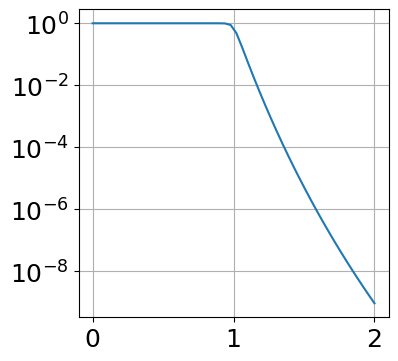

In [23]:
n=30
xval = jnp.linspace(0.,2.)
yval = 1./jnp.sqrt(1 + xval**(2.*n))
fig = plt.figure(figsize=(4,4))
plt.plot(xval,yval)
plt.yscale('log')
plt.grid();

In [24]:
def count_smooth(r,X,n=30):
    u = X/r
    return jnp.sum(1./jnp.sqrt(1 + u**(2.*n)))

In [25]:
count_smooth(1.,X)  # approx 6

Array(5.90886867, dtype=float64)

In [26]:
jax.grad(count_smooth)(1.,X)  # gradient =/= 0 !

Array(4.81316697, dtype=float64, weak_type=True)

A possible use case:
optimization of a ball with maximum mass but smaller surface that contains some points in a dataset.

[Google collab here](https://colab.research.google.com/drive/1LNXVmepv369EpCE7U5vxNFLb7uKdcqZM#scrollTo=zyUS4NQP7-rI)

In [27]:
def mass(params,data):
    r2 = params[3]**2
    center = params[:3]
    data_c = data-center
    d2 = jnp.sum(data_c**2,axis=1)
    return count_smooth(d2/r2)

def surf(params):
    r2 = params[3]**2
    return 4.*jnp.pi*r2

def loss(params,data,k_factor=1.0):
    return - mass(params,data)*k_factor +  surf(params)

# Non-scalar function : Jacobian (See Hessian after)
For non-scalar functions, they are two functions (`jacfwd` and `jacrev`) to compute the Jacobian.
Nb. `grad` is based on `jacrev`.

$$
f(W,x) = y = W x \quad \mathrm{with} \quad  W=\begin{pmatrix}
1 & 2 \\
3 & 5
\end{pmatrix}
$$
We can write the result as
$$
\begin{cases}
y_1 &= W_{11} \times x_1 + W_{12} \times x_2 + W_{21}\times 0 + W_{22}\times 0 \\
y_2 &=W_{11}\times 0 + W_{12}\times 0 + W_{21}\times x1 + W_{22}\times x2
\end{cases}
$$
So, we have 4 parameters as $W$ elements ($n$) and 2 outputs for $y$ ($m$).
We expect a Jacobian matrix of rank $m \times n$. With $x=(x_1,x_2)$
$$
\begin{pmatrix}
\frac{\partial y_1}{\partial W_{11}}=x_1 & \frac{\partial y_1}{\partial W_{12}}= x_2 & \frac{\partial y_1}{\partial W_{21}}=0 & \frac{\partial y_1}{\partial W_{12}}=0 \\
\frac{\partial y_2}{\partial W_{11}}=0 & \frac{\partial y_2}{\partial W_{12}}= 0 & \frac{\partial y_2}{\partial W_{21}}=x_1 & \frac{\partial y_2}{\partial W_{12}}=x_2 \\
\end{pmatrix}
$$

In fact, the output keeps track of the parameter shape:
$$
\begin{bmatrix}
\begin{pmatrix}
\frac{\partial y_1}{\partial W_{11}}=x_1 & \frac{\partial y_1}{\partial W_{12}}= x_2 \\ \frac{\partial y_1}{\partial W_{21}}=0 & \frac{\partial y_1}{\partial W_{12}}=0
\end{pmatrix}
\\
\begin{pmatrix}
\frac{\partial y_2}{\partial W_{11}}=0 & \frac{\partial y_2}{\partial W_{12}}= 0 \\ \frac{\partial y_2}{\partial W_{21}}=x_1 & \frac{\partial y_2}{\partial W_{12}}=x_2
\end{pmatrix}
\end{bmatrix}
$$
So a tensor rank that I write as $(2,(2,2))$ which has array shape of $(2,2,2)$.

In [28]:
def fvec(W,x):
    return W @ x

In [29]:
W = jnp.array([[1., 2.],[3.,5.]])
x = jnp.array([-1.,1.])
W,x

(Array([[1., 2.],
        [3., 5.]], dtype=float64),
 Array([-1.,  1.], dtype=float64))

In [30]:
fvec(W,x)

Array([1., 2.], dtype=float64)

In [31]:
# W is the parameter (first argument by default)
Jfwd =jacfwd(fvec)(W,x)
print("Jacobian shape: ",Jfwd.shape,"\n J=",Jfwd)

Jacobian shape:  (2, 2, 2) 
 J= [[[-1.  1.]
  [ 0.  0.]]

 [[ 0.  0.]
  [-1.  1.]]]


In [32]:
# There is a second type of computation of the Jacobian
Jrev =jacrev(fvec)(W,x)
jnp.all(Jrev==Jfwd)

Array(True, dtype=bool)

**Warning**: (if we flatten the parameter matrix/tensor)

- `jacfwd` is designed for $\mathbb{R}^n \rightarrow \mathbb{R}^m$ with $n\ll m$ (*tall matrix*)

- `jacrev` is designed for $\mathbb{R}^n \rightarrow \mathbb{R}^m$ with $m\ll n$ (*wide matrix*)

The last case is particularly adapted when we have a lot of parameters ($n$) with a few outputs ($m$). But this will imply restriction for the coding (`fori_loop` and `while` loop) see [doc](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#summary)






# Auto-diff on multi-args function

The differentiation is by default on the 1st argument of the function but this is not exclusive


In [33]:
def func(x, y):
    return 2 * x * y

print(grad(func)(3., 4.))  # 8.                 # df/dx (1st arg) evaluated @ (3,4)
print(grad(func, argnums=0)(3., 4.))  # 8.      # df/dx    evaluated @  (3,4)
print(grad(func, argnums=1)(3., 4.))  # 6       # df/dy    evaluated @  (3,4)
print(grad(func, argnums=(0, 1))(3., 4.))  # (8., 6.)  # both firs derivatives evaluated at once

8.0
8.0
6.0
(Array(8., dtype=float64, weak_type=True), Array(6., dtype=float64, weak_type=True))


# Example via the minimization of the Mean Squared Error (MSE)

## Model, loss
In passing: jnp.exp, jnp.sin ... are vectorized so  `model` and ``loss_fun` do not need vmap.

In [10]:
def model(p, x):
    return jnp.exp(-x*p[0])*jnp.sin(x*p[1])

def loss_fun(p, xi, yi):
    yhat = model(p, xi)
    return jnp.mean( (yhat - yi)**2 )

## Dataset
Let us now generate a dataset. Look at random number generation

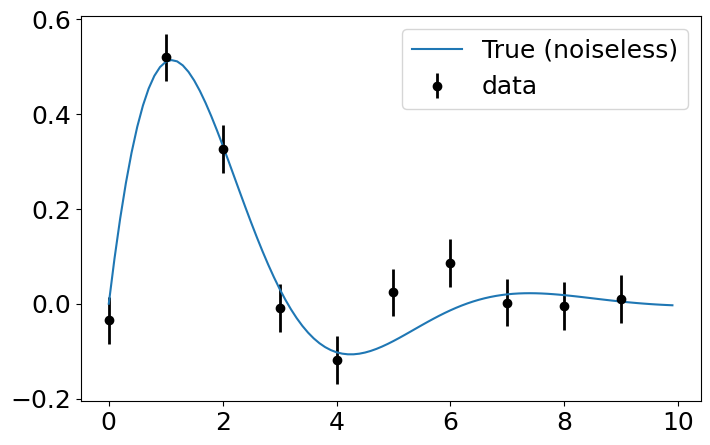

In [11]:
# dataset
ptrue = jnp.array([0.5,1])

xin = jnp.arange(0,10,1.)
yerr = 0.05
key, subskey = jax.random.split(jax.random.PRNGKey(42),2) #simple way to give a key to the RNG
#key can be used here after if necessary
y_true =  model(ptrue, xin)
yin = y_true + yerr*jax.random.normal(jax.random.PRNGKey(42),shape=xin.shape)

#plot
xvals = jnp.arange(0,10,0.1)
plt.figure(figsize=(8,5))
plt.errorbar(xin,yin,yerr=yerr, fmt='o', linewidth=2, capsize=0, c='k', label="data");
plt.plot(xvals,model(ptrue, xvals), label='True (noiseless)')
plt.legend();

## Gradient descent method

In [12]:
@jit #see later Just-In-Time compilation
def gradient_descent_step(p, xi, yi, lr=0.1):
    return p - lr * jax.grad(loss_fun)(p, xi, yi)

Below is a simple minimizer from scratch with a for loop. We will use a more JAXy version later

In [13]:
def minimzer(loss_fun, x_data, y_data, par_init, method, verbose=True):
    p_cur = par_init
    new_loss=jnp.inf

    for t in range(5000):

        if (t % 100 == 0) and verbose:
            print(t, p_cur,new_loss)

        old_loss = new_loss
        new_p = method(p_cur, x_data,y_data)
        new_loss = loss_fun(new_p, x_data,y_data)

        if jnp.abs(new_loss-old_loss) < 1e-9:
            print(f"Converged after {t} epochs: p = {new_p}, loss = {new_loss}")
            break

        p_cur = new_p

    return p_cur

In [14]:
par_mini_GD = minimzer(loss_fun, x_data=xin, y_data=yin, par_init=jnp.array([0., 0.5]),
                    method=partial(gradient_descent_step, lr=0.5), verbose=True)

0 [0.  0.5] inf
100 [2.15953273 0.56389911] 0.033247239677726276
200 [1.59564364 0.98068681] 0.023004943889561494
300 [0.59298792 1.08997104] 0.0019512935874766468
Converged after 370 epochs: p = [0.52381757 1.10343296], loss = 0.0015533005412891193


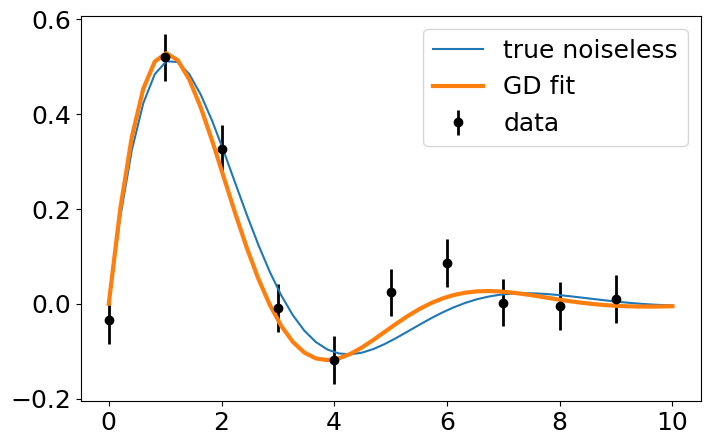

In [15]:
plt.figure(figsize=(8,5))
plt.errorbar(xin,yin,yerr=yerr, fmt='o', linewidth=2, capsize=0, c='k', label="data")
x_val = jnp.linspace(0.,10,50)
plt.plot(x_val,model(ptrue, x_val),label="true noiseless")
plt.plot(x_val,model(par_mini_GD, x_val) ,lw=3,label="GD fit")
plt.legend();


## Use 2nd order method

By default the implementation is `jax.hessian(f)=jacfwd(jacrev(f))`

In [16]:
# a small check
A = jax.random.uniform(jax.random.PRNGKey(10),(3, 3))
C = jnp.dot(A, A.transpose()) # a Covariance Matrix

In [19]:
def f(x,C):  #x parameter, C is fixed
    return 0.5 * x.T @ C @ x

In [20]:
x=jnp.array([0.,0.,0.])
jnp.all(jax.hessian(f)(x,C)==C)

Array(True, dtype=bool)

In [21]:
gLoss = lambda p,xi,yi: jacfwd(loss_fun)(p,xi,yi)
hLoss = lambda p,xi,yi: jax.hessian(loss_fun)(p,xi,yi)

@jit
def oneStepNewton(p,xi,yi,lr=1.0):
    return p - lr * jnp.linalg.inv(hLoss(p,xi,yi)) @ gLoss(p,xi,yi)


In [22]:
par_mini_Newton = minimzer(loss_fun, x_data=xin, y_data=yin, par_init=jnp.array([0., 0.5]),
                    method=partial(oneStepNewton, lr=0.1), verbose=True)

0 [0.  0.5] inf
100 [0.07535074 0.00358029] 0.039375743499862684
Converged after 183 epochs: p = [0.52373613 1.10348083], loss = 0.001553297865019117


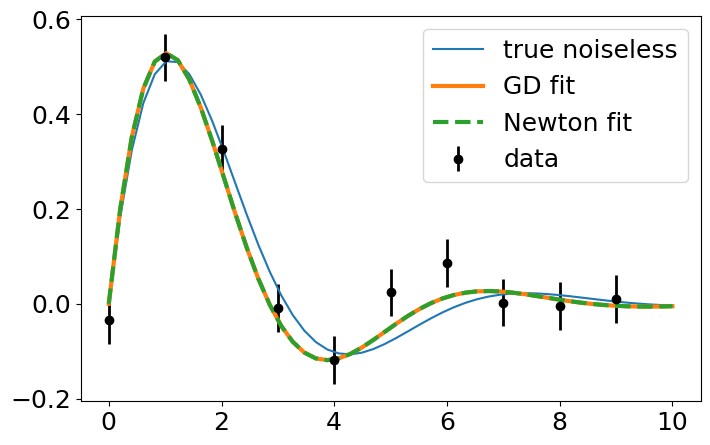

In [23]:
plt.figure(figsize=(8,5))
plt.errorbar(xin,yin,yerr=yerr, fmt='o', linewidth=2, capsize=0, c='k', label="data")
x_val = jnp.linspace(0.,10,50)
plt.plot(x_val,model(ptrue, x_val),label="true noiseless")
plt.plot(x_val,model(par_mini_GD, x_val) ,lw=3,label="GD fit")
plt.plot(x_val,model(par_mini_Newton, x_val),ls='--',lw=3,label="Newton fit")
plt.legend();

# Gradient/Vmap...wrt  tuples, lists, and dicts

dictionnary

In [46]:
def f(p:dict,x):
    return p["a"]**2 + p["b"]*x

$$
∂ f/\partial p(a) = 2 p(a), \qquad ∂ f/\partial p(b) = x
$$

In [47]:
p= {"a":3.,"b":1.}
x = 10.
print(grad(f)(p,x))

{'a': Array(6., dtype=float64, weak_type=True), 'b': Array(10., dtype=float64, weak_type=True)}


$$\partial f / \partial x = p(b)$$

In [48]:
print(grad(f, argnums=1)(p,x))

1.0


tuple

In [49]:
def f(p:tuple,x):
    return p[0]**2 + p[1]*x

In [50]:
p= (3.,1.)
x = 10.
print(grad(f)(p,x))

(Array(6., dtype=float64, weak_type=True), Array(10., dtype=float64, weak_type=True))


list

In [51]:
def f(p:list,x):
    return p[0]**2 + p[1]*x

In [52]:
p= [3.,1.]
x = 10.
print(grad(f)(p,x))

[Array(6., dtype=float64, weak_type=True), Array(10., dtype=float64, weak_type=True)]


We will see later user (PyTree) structure that allows for differentiation, vmaping, etc

There are also special functions for Jacobian and vector product.
$f: \mathbb{R}^n → \mathbb{R}^m$ then the Jacobian is $∂f \in \mathbb{R}^{m\times n}$. But, at $x$ we can define a tangent space to the manyfold where $x$ lives, and similarly at $f(x)$ we can define a tangent space to the manyfold where $f(x)$ lives. The Jacobian is the mapping between these two spaces.

![Jacobian](./figures/Jacobian.png?raw=1)

We can define
- `jvp` for Jacobian vector product (aka forward mode) $v\in \mathbb{R}^n$ (ie. a vector tangent at $x$ in $\mathbb{R}^n$)  : $(x,v)→(f(x),∂f . v)$
- `vjp` for vector Jacobian product (aka backward mode) $v\in \mathbb{R}^m$ (ie. a vector tangent at $f(x)$ in $\mathbb{R}^m$)  : $(x,v)→(f(x),v^T . ∂f)$

There is the possibility to code user `jax.custom_jvp()` and `jax.custom_vjp()` to define custom differentiation rules for Python functions that are already JAX-transformable...


More info [here](https://jax.readthedocs.io/en/latest/_tutorials/advanced-autodiff.html#hessian-vector-products-with-jax-grad-of-jax-grad)

In [53]:
# Trivial example
@partial(jax.custom_jvp, nondiff_argnums=(1,))
def _sink(x,k):
    return jnp.sin(k*x)

@_sink.defjvp
def _sink_jvp(k,primals, tangents):
    (x,), (x_dot,) = primals, tangents
    return _sink(k,x), k*jnp.cos(k*x) * x_dot

In [54]:
k=3.
x = jnp.arange(0,2.,0.1)*jnp.pi

In [55]:
user_jvp = vmap(grad(_sink), in_axes=(0,None))(x,k)
print(user_jvp)
jax_auto_diff= vmap(grad(lambda v:jnp.sin(k*v)))(x)
print("Verif: ",jnp.all(user_jvp==jax_auto_diff))


[ 3.00000000e+00  1.76335576e+00 -9.27050983e-01 -2.85316955e+00
 -2.42705098e+00 -5.51091060e-16  2.42705098e+00  2.85316955e+00
  9.27050983e-01 -1.76335576e+00 -3.00000000e+00 -1.76335576e+00
  9.27050983e-01  2.85316955e+00  2.42705098e+00  1.65327318e-15
 -2.42705098e+00 -2.85316955e+00 -9.27050983e-01  1.76335576e+00]
Verif:  True


# Control Flows: loops...  using jax.lax

## jax.lax.fori_loop
the equivalent code is
```python
def fori_loop(start, stop, body_fun, init_val):
  val = init_val
  for i in range(start, stop):
    val = body_fun(i, val)
  return val
```

basic use to get the $\sum_{i=0}^N i^2$

In [56]:
def body(i,val):
      return val+i**2
val_init=0
N=10
res = jax.lax.fori_loop(0,N+1,body,val_init)
print(f"{res}, exact: {N*(N+1)*(2*N+1)//6}")

385, exact: 385


We will see the effect of fixed vs dynamic bounds.

## jax.lax.scan

equivalen code

```python
def scan(f, init, xs, length=None):
  if xs is None:
    xs = [None] * length
  carry = init
  ys = []
  for x in xs:
    carry, y = f(carry, x)
    ys.append(y)
  return carry, np.stack(ys)
```

In [57]:
def body(x, i):
    return x, jnp.sum(x**i)

N=10
x = jnp.arange(0,N+1)
i_expo = jnp.arange(4)
_, res = jax.lax.scan(body,x,i_expo)
print(jnp.vstack(((i_expo,res))).T)

[[   0   11]
 [   1   55]
 [   2  385]
 [   3 3025]]


### While

equivalent code

```python
def while_loop(cond_fun, body_fun, init_val):
  val = init_val
  while cond_fun(val):
    val = body_fun(val)
  return val
```
See an example later

## Condition
Here a function $f(x,y)$ such that
$$
f(x,y) = \begin{cases}
y^2 & if x\leq 1 \\
y & if\ x>1
\end{cases}
$$


In [58]:
def f(x,y):
    return jax.lax.cond(x>1,lambda p: p, lambda p: p**2,operand=y)

print(f(1.,2.),f(2.,2.))

4.0 2.0


## Warning 1
`jax.lax` compiles the body functions (JIT is in under the hood).
In case of `cond` both branches are compiled but one is executed except
when used with a `vmap` where it is turned into `jax.lax.select` leading
to evaluation of both branches even if the compilor try to do its best
to elide computations.



## Warning 2

Unlike that Python version, `fori_loop` is implemented in terms of either a call to `jax.lax.while_loop` or a call to `jax.lax.scan`. If the trip count is static (meaning known at tracing time, perhaps because lower and upper bounds are Python integer literals) then the `fori_loop` is implemented in terms of `scan` and **reverse-mode autodiff is supported**; otherwise, a `while_loop` is used and **reverse-mode autodiff is not supported**.

Here is a table from [the JAX doc](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#python-control-flow-jit)


$$
\begin{array} {r|rr}
\hline
\textrm{construct}
& \textrm{jit}
& \textrm{grad} \\
\hline
\textrm{if} & ❌ & ✔ \\
\textrm{for} & ✔* & ✔\\
\textrm{while} & ✔* & ✔\\
\textrm{lax.cond} & ✔ & ✔\\
\textrm{lax.while_loop} & ✔ & \textrm{fwd}\\
\textrm{lax.fori_loop} & ✔ & \textrm{fwd if dynamic bounds} \\
\textrm{lax.scan} & ✔ & ✔\\
\hline
\end{array}
$$
 ∗ = argument-value-independent loop condition - unrolls the loop

## An application: A minimizer where carry is updated w/o changing its structure

In [59]:
from jax.example_libraries.optimizers  import adam,sgd

sum_abs = lambda x: jnp.sum(jnp.abs(x))

def minimize(
    fun, inputs, optimizer, schedule=1e-4, maxiter=10, gtol=1e-2,
):
    """Optimizes inputs to minimize output of fun
    Args:
        fun: the function (e.g. energy potential)
        inputs: initial inputs
        optimizer: any jax.example_libraries.optimizers
        schedule: learning rate schedule for optimizer
        maxiter: maximum number of optimizer steps
        gtol: cutoff for gradients to stop early
    """
    init_optimizer, update_optimizer, get_inputs = optimizer(schedule)
    energy_gradient = grad(lambda x: jnp.sum(fun(x)))
    opt_state = init_optimizer(inputs)
    gradient = energy_gradient(inputs)
    sum_abs_gradient = sum_abs(gradient)

    carry_init = (0, opt_state, gradient, sum_abs_gradient, inputs)

    def step_once(carry):
        (step, opt_state, gradient, sum_abs_gradient, inputs) = carry
        opt_state = update_optimizer(step, gradient, opt_state)
        inputs = get_inputs(opt_state)
        gradient = energy_gradient(inputs)
        sum_abs_gradient = sum_abs(gradient)
        carry = (step + 1, opt_state, gradient, sum_abs_gradient, inputs)
        return carry

    def noop(carry):
        return carry

    def body_fn(carry, x):
        sum_abs_gradient = carry[-2]
        return jax.lax.cond(sum_abs_gradient < gtol, noop, step_once, carry), None   #<<<< condition ex.

    carry, _ = jax.lax.scan(body_fn, carry_init, None, length=maxiter)
    return carry

In [60]:
def fun(x):
        return (x + 2)**2*(x - 1)*(x - 4)

x0=0.0 # guess
_, final_state, _, _, _ =  minimize(fun,x0,optimizer=sgd, schedule=1e-2, maxiter=100,gtol=1e-6)

xFinal=final_state.packed_state[0][0]
xTrue = 2.921164609606623  # best mini  #x=-2 2nd mini
print(f"optimal x={xFinal:.8f}, truth: {xTrue:.8f}, err: {xFinal-xTrue:6g}")

optimal x=2.92116460, truth: 2.92116461, err: -1.22869e-08


# Other switch mechanisms via jax.numpy

## jnp.where

In [61]:
def f(x, params):
    R0 = params["R0"]
    v  = params["v"]
    k  = params["k"]
    tau =  params["tau"]
    return jnp.where(x < 0, R0 + v*x, R0 + v*x - k*(1.-jnp.exp(-x/tau)))
    #alternative return jax.lax.select(x < 0, R0 + v*x, R0 + v*x - k*(1.-jnp.exp(-x/tau)))

par_true={"R0":35.0, "v":2.20, "k":15.5, "tau": 1.0}
fpar=partial(f,params=par_true) # diff wrt first arg
gfpar = grad(fpar)
vgfpar = vmap(gfpar)

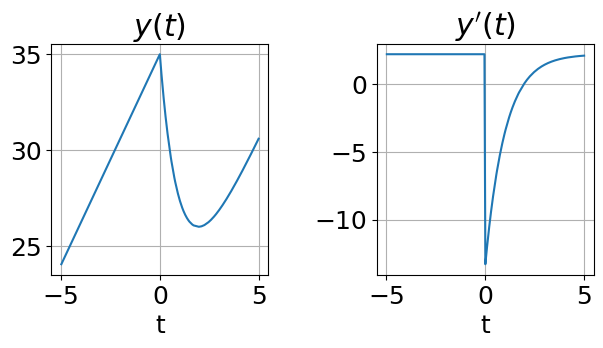

In [62]:
t = jax.random.uniform(jax.random.PRNGKey(42),minval=-5.,maxval=5.0,shape=(200,))
t=jnp.append(t,0.0)
t=jnp.sort(t)

fig,axs = plt.subplots(1,2,figsize=(7,3))
axs[0].plot(t,fpar(t))
axs[0].set_title("$y(t)$")
axs[1].plot(t,vgfpar(t))
axs[1].set_title("$y^\prime(t)$")
for ax in axs.ravel():
    ax.set_xlabel("t")
    ax.grid();
plt.subplots_adjust(wspace=0.5)

## jnp.select

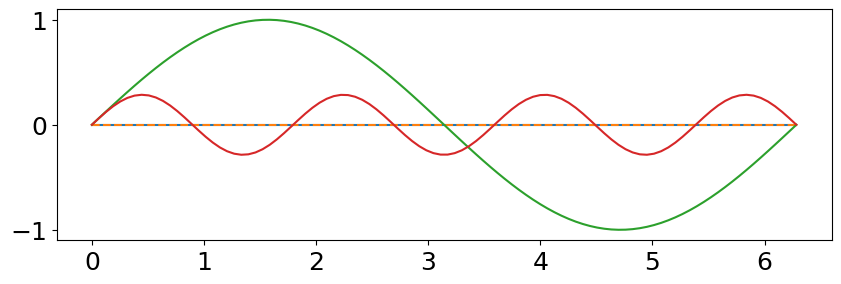

In [63]:
def func(x,n):
    def g(x,n):
        return jnp.sin(n*x)/n
    def g0(x):
        return 0.
    return jnp.select([n==0],[g0(x)],default=g(x, n))
vals = jnp.linspace(0,2*jnp.pi,100)

plt.figure(figsize=(10,3))
plt.plot(vals,func(vals,0))
plt.plot(vals,func(vals,0.),ls='--')  # nb. if one uses [jax.lax.eq(n,0)] as test then n=0. will crash
plt.plot(vals,func(vals,1.))
plt.plot(vals,func(vals,3.5))

#  More vmap... vectorization partielle: in-axes

In [64]:
def f(p:dict,x):
    return p["a"]**2 + p["b"]*x

In [65]:
# We vectorize on the "b" values of the dictionnary as array of (1,2,3)
# p(a)=1, x=10
print(vmap(f, in_axes=({"a": None, "b": 0},None))({"a":1.,"b":jnp.array([1.,2.,3.])},10.))

[11. 21. 31.]


In [66]:
# make p(b)=2, x=10 and vectorize upon p(a)
vmap(f, in_axes=({"a":0, "b": None},None))({"a":jnp.array([1.,2.,3.]),"b":2.0},10)

Array([21., 24., 29.], dtype=float64)

A bit more in_axis manipulations

In [67]:
def func(a,b,x):
    return a**2 + b*x

In [68]:
vfunc = vmap(func, in_axes=(0,None,None))  # vectorize on "a"

In [69]:
vfunc(jnp.array([1.,2.,3.]), 1.,10.)

Array([11., 14., 19.], dtype=float64)

In [70]:
# map over 2 axis : "a" and "b"
vvfunc = vmap(vmap(func, in_axes=(0,None,None)),in_axes=(None,0,None))

In [71]:
vvfunc(jnp.array([1.,2.,3.]),jnp.array([0.,1.,4.,5.]),10.)
# x= 10
# a:(1,2,3) b: 0
# a:(1,2,3) b: 1
# a:(1,2,3) b: 4
# a:(1,2,3) b: 5

Array([[ 1.,  4.,  9.],
       [11., 14., 19.],
       [41., 44., 49.],
       [51., 54., 59.]], dtype=float64)

In [72]:
# Python list comprehension equiv.
[[func(ai,bj,x=10.) for ai in [1,2,3]] for bj in [0.,1.,4.,5.]]

[[1.0, 4.0, 9.0], [11.0, 14.0, 19.0], [41.0, 44.0, 49.0], [51.0, 54.0, 59.0]]

In [73]:
vmap(func,in_axes=(0,0,None))(jnp.array([1.,2.,3.]),jnp.array([0.,1.,4.]),10.)
# here map a,b at the same times : requires than arrays have the same sizes
#x=10
# a:1 b:0
# a:2 b:1
# a:3 b:4

Array([ 1., 14., 49.], dtype=float64)

In [74]:
# Python list comprehension equiv.
[func(ai,bj,x=10.) for ai,bj in zip([1,2,3],[0.,1.,4.,5.])]

[1.0, 14.0, 49.0]

Now, "0" in the above in_axes means the first dimension of each "a" and "b" args.

What about if "b" is a matrix, and "a" a vector

In [75]:
a = np.array([1.,2.,3.])
b = np.array([[0.,1.,4.],[1.,2.,8.]])

In [76]:
jnp.array([func(a[i],b[:,i],10) for i in range(len(a))])

Array([[ 1., 11.],
       [14., 24.],
       [49., 89.]], dtype=float64)

In [77]:
# here is the vmap equivalent
vmap(func,in_axes=(0,1,None))(a,b,10.)

Array([[ 1., 11.],
       [14., 24.],
       [49., 89.]], dtype=float64)

# An exemple that uses control flows & vmap

Let us explore the Julia set. Define $(c_x,c_z)$ then inititialiaze
$$
x_0 = x_{pix}; y_0 = y_{pix}
$$
then iterate
$$
\begin{cases}
x_{n+1} &= x_n^2 - y_n^2 + c_x \\
y_{n+1} &= 2x_n y_n + c_y
\end{cases}
$$

As soon as $(x_n,y_n)$ leaves the disk of center $(0,0)$ and radius $r=2$ we stop the recursion;  as well as if it $n$ reaches an arbitrary maximum value ("MAX_ITERATION") meaning that the pixel $(x_0,y_0)$ belongs to the Julia fractal. Depending on the couple $(c_x,c_y)$, we obtain different fractals.

In [24]:
jax.clear_caches() # just for commodity
def julia_set(cx,cy, XMIN, XMAX, YMIN, YMAX, LARGEUR, HAUTEUR, MAX_ITERATION):

    def func(ix,iy):
        def body(val):
            n,x,y = val
            xn = x * x - y * y + cx
            yn = 2 * x * y     + cy
            n = n+1
            return (n,xn,yn)

        cond_fun = lambda p : ((p[1]**2 + p[2]**2 < 4.) & (p[0] < MAX_ITERATION))

        x0 = (ix * (XMAX - XMIN) / LARGEUR + XMIN)
        y0 = (iy * (YMIN - YMAX) / HAUTEUR + YMAX)
        u = (0,x0,y0)
        u = jax.lax.while_loop(cond_fun,body,u)
        n = u[0]

        pixel_val = jax.lax.cond(jnp.isclose(n,MAX_ITERATION),
                                 lambda _: 0.,
                                 lambda p: 0.222*((3*p)/256) + 0.666*(p/256) + 0.111*((10*p)/256),
                                operand=n)
        return pixel_val

    #See Multi_GPUs nb
    #X,Y = jnp.meshgrid(jnp.arange(0, LARGEUR),jnp.arange(0, HAUTEUR))
    #mapped = jax.vmap(func, in_axes=(0, 0))
    #result = mapped(X,Y)

    #mapped = jit(vmap(vmap(func, in_axes=(None, 0)), in_axes=(0, None)))
    mapped = vmap(vmap(func, in_axes=(None, 0)), in_axes=(0, None))
    result = mapped(jnp.arange(0, LARGEUR), jnp.arange(0, HAUTEUR))

    return result

In [25]:
XMIN, XMAX, YMIN, YMAX = -1.25, 1.25, -1.25, 1.25   # physical sapce
LARGEUR, HAUTEUR = 2048, 2048                       # image size
MAX_ITERATION = 150
eps=0.001
cx, cy = 0.285+eps, 0.01+eps

jax.clear_caches() # here just for convenience
img = julia_set(cx,cy,
                XMIN, XMAX, YMIN, YMAX,
                LARGEUR, HAUTEUR,
                MAX_ITERATION)

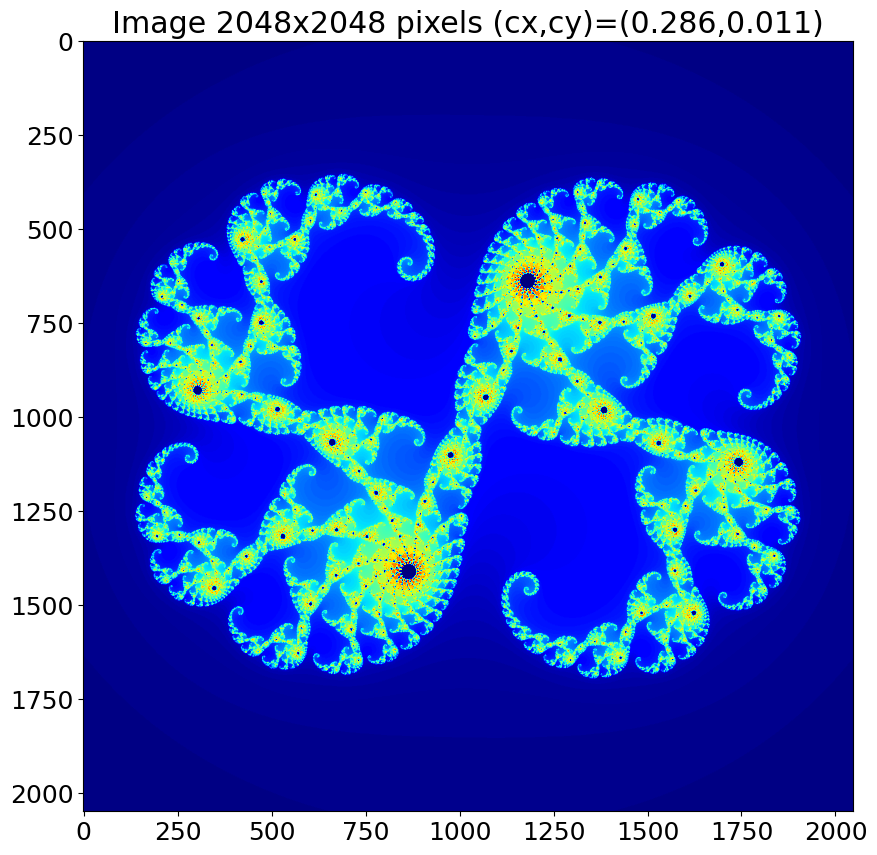

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(img,cmap=mpl.cm.jet);
plt.title(fr"Image {HAUTEUR}x{LARGEUR} pixels (cx,cy)=({cx:.3f},{cy:.3f})");
plt.show() # takes more time to display than to compute
MatplotlibClearMemory()

# PyTree: a user structure adapted to JAX (vmap,grad)
(nb see later in the tuto for JIT)



> A pytree is a container-like structure built out of container-like Python objects — “leaf” pytrees and/or more pytrees. A pytree can include lists, tuples, and dicts. A leaf is anything that’s not a pytree, such as an array, but a single leaf is also a pytree.

It can be **list, tuples, dictionaries, namedtuple, OrderedDict, and None (!)** But you can "register" your **own strcture**.


An example  is the `class Cosmology` of [jax-cosmo](https://github.com/DifferentiableUniverseInitiative/jax_cosmo/blob/master/jax_cosmo/core.py) w/o any functions.

Below is a shorter class with 2 attributes

In [30]:
from jax.tree_util import register_pytree_node_class
@register_pytree_node_class
class Params:
    def __init__(self, a, b):
        self._a = a
        self._b = b
        
    def __repr__(self):
        return f"Params(a={self._a}, b={self._b})"
    @property
    def a(self):
        return self._a
    @property
    def b(self):
        return self._b
    
    # the two required methods
    def tree_flatten(self):
        children = (self._a, self._b)  # traced variables (see later)
        aux_data = {}                  # non-traced
        return (children, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children, **aux_data) # instantiation of a new object Params

In [31]:
my_params = Params(3.,1.)
my_params

Params(a=3.0, b=1.0)

In [32]:
def g(p: Params,x):
    return (p.a)**2 + (p.b)*x

In [33]:
print(grad(g)(my_params,10)) # as easy as arrays, dicts, lists

Params(a=6.0, b=10.0)


In [34]:
# vmaping along the "b" parameter (2nd field) of Params class
print(vmap(g, in_axes=(Params(None, 0), None))(Params(3., jnp.array([1.,2.,3.])), 10))

[19. 29. 39.]


nb.   this `jnp.array([Params(3.0,1.0),Params(3.0,2.0),Params(3.0,3.0)])
` is not possible. You do not map `g` over `Params`objects but over their arguments.
see [jax this discussion](https://github.com/jax-ml/jax/discussions/5322)

# Just-In-Time compilation
(more with Wasim's talk)

    - We have seen that for `jax.lax` functions JIT is under the hood
    - JIT is not unique to JAX, see e.g. `numba`
    - JIT compiles the code and cache it for the device you are running: eg. CPU, GPU, TPU

In [39]:
jax.clear_caches()# just for convenience if repeated executions
@jit  # decorator but one can use jf = jit(f)  => jf(x)
def f(x):
    print("1) x",x)                      # standard python print
    jax.debug.print("2) x: {}",x)        # JAX debug similar to f-string
    return jnp.sin(x)

In [40]:
f(jnp.pi/4.)

1) x Traced<ShapedArray(float64[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
2) x: 0.7853981633974483


Array(0.70710678, dtype=float64, weak_type=True)

In [41]:
f(jnp.pi/2.)  # notice that the print 1) does not appears... cache is used

2) x: 1.5707963267948966


Array(1., dtype=float64, weak_type=True)

In [42]:
f(jnp.pi/4*jnp.arange(5)) # recompilation  float->jnp.array 5 elements

1) x Traced<ShapedArray(float64[5], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
2) x: [0.         0.78539816 1.57079633 2.35619449 3.14159265]


Array([0.00000000e+00, 7.07106781e-01, 1.00000000e+00, 7.07106781e-01,
       1.22464680e-16], dtype=float64, weak_type=True)

In [43]:
f(jnp.pi/6*jnp.arange(7))  # recompilation jnp.array 5 elements -> jnp.array 7 elements

1) x Traced<ShapedArray(float64[7], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
2) x: [0.         0.52359878 1.04719755 1.57079633 2.0943951  2.61799388
 3.14159265]


Array([0.00000000e+00, 5.00000000e-01, 8.66025404e-01, 1.00000000e+00,
       8.66025404e-01, 5.00000000e-01, 1.22464680e-16],      dtype=float64, weak_type=True)

In [44]:
f(jnp.pi/12*jnp.arange(7))  # use cache

2) x: [0.         0.26179939 0.52359878 0.78539816 1.04719755 1.30899694
 1.57079633]


Array([0.        , 0.25881905, 0.5       , 0.70710678, 0.8660254 ,
       0.96592583, 1.        ], dtype=float64, weak_type=True)

An example using a square root simple algo

In [46]:
jax.clear_caches()
def jax_sqrt_rec(x):
    def body(i,val):
        return (val+x/val)/2.
    return jax.lax.fori_loop(0,10,body,x) #jax.lax compile body by default

vgradsqrt = jit(vmap(grad(jax_sqrt_rec))) # in fact jit is propagated

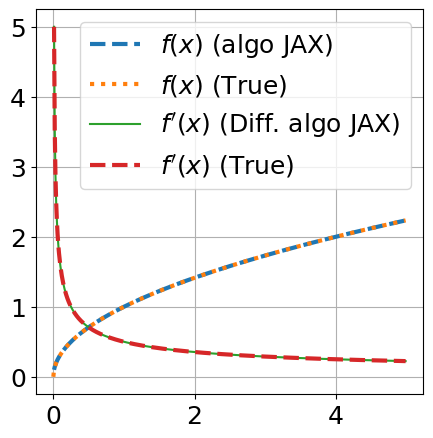

In [48]:
plt.figure(figsize=(5,5))
x = jnp.arange(0,5,0.01)
plt.plot(x, jax_sqrt_rec(x), lw=3,ls='--', label=r"$f(x)$ (algo JAX)")
plt.plot(x, jnp.sqrt(x), lw=3,ls=':', label=r"$f(x)$ (True)")

plt.plot(x, vgradsqrt(x), label=r"$f^\prime(x)$ (Diff. algo JAX)")
plt.plot(x, 1/(2*jnp.sqrt(x)), lw=3,ls='--',label=r"$f^\prime(x)$ (True)")
plt.legend()
plt.grid();

## Some JIT crashes with solutions

### Static (1) : fori_loop bounds

In [8]:
jax.clear_caches()
@jit
def jax_sqrt_rec(x,N):  # N : maximum loop
    def body(i,val):
        return (val+x/val)/2.
    return jax.lax.fori_loop(0,N,body,x)

In [9]:
jax_sqrt_rec(2.,10) # sqrt(2)

Array(1.41421356, dtype=float64, weak_type=True)

In [10]:
jacfwd(jax_sqrt_rec)(2.,10), 1/(2.*jnp.sqrt(2.))

(Array(0.35355339, dtype=float64, weak_type=True),
 Array(0.35355339, dtype=float64, weak_type=True))

In [11]:
grad(jax_sqrt_rec)(2.,10)  # crash

ValueError: Reverse-mode differentiation does not work for lax.while_loop or lax.fori_loop with dynamic start/stop values. Try using lax.scan, or using fori_loop with static start/stop.

As explained:
1. `grad` is based on the Reverse-mode differentiation (jacrev)
2. `fori_loop` is implemented either with `scan` if bounds known at tracing time or `while_loop` if dynamic bounds
3. `while_loop` does not accept Reverse-mode differentiation

Here is a solution.

In [99]:
jax.clear_caches()
@partial(jit, static_argnames=("N"))    #<--------- alternative static_argnums=(1,)
def jax_sqrt_rec(x,N):  # N : maximum loop
    def body(i,val):
        return (val+x/val)/2.
    return jax.lax.fori_loop(0,N,body,x)

In [100]:
grad(jax_sqrt_rec)(2.,100)   # ok N is no more traced

Array(0.35355339, dtype=float64, weak_type=True)

### static (2): array sizes

In [13]:
# Numpy version
def ex1_numpy(x):
    x = x.T @ x
    print("in= ",x)
    x = x.reshape(np.prod(x.shape))  # flatenning... but it is to play with x.shape
    y = np.diff(x)
    print("run diff.:",y)
    y=np.sum(y)
    print("Numpy y:",y)

# JAX
def ex1(x):
    x = x.T @ x
    size = jnp.prod(jnp.array(x.shape))
    print("\nJAX Dbg size: ",size)
    return jnp.sum(jnp.diff(x.reshape((size,))))

In [14]:
x = np.arange(0,12.,1).reshape((3, 4))
ex1_numpy(x)

print("JAX   y:",ex1(x))

in=  [[ 80.  92. 104. 116.]
 [ 92. 107. 122. 137.]
 [104. 122. 140. 158.]
 [116. 137. 158. 179.]]
run diff.: [ 12.  12.  12. -24.  15.  15.  15. -33.  18.  18.  18. -42.  21.  21.
  21.]
Numpy y: 99.0

JAX Dbg size:  16
JAX   y: 99.0


Let us now make a jitted version.

In [15]:
jax.clear_caches()
x = jnp.arange(0,12.,1).reshape((3, 4))
jit(ex1)(x)


JAX Dbg size:  Traced<ShapedArray(int64[])>with<DynamicJaxprTrace(level=1/0)>


TypeError: Shapes must be 1D sequences of concrete values of integer type, got (Traced<ShapedArray(int64[])>with<DynamicJaxprTrace(level=1/0)>,).
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
The error occurred while tracing the function ex1 at /var/folders/x6/dxq9d35s0q59v_mxfkkptl3m0000gp/T/ipykernel_8740/1757260229.py:12 for jit. This value became a tracer due to JAX operations on these lines:

  operation a:i64[2] = convert_element_type[new_dtype=int64 weak_type=False] b
    from line /var/folders/x6/dxq9d35s0q59v_mxfkkptl3m0000gp/T/ipykernel_8740/1757260229.py:14 (ex1)

There is a crash because of "reshape" as  "***Shapes must be 1D sequences of concrete values of integer type***". But the solution to put "x" as static is not our solution as we want for instance compute gradiant, vmap...

In fact: `x.shape` is performed `statically`, but `jnp.prod` is `traced` (see the print)

Nb: `jnp.diff(x.flatten())` would have not crashed, the `ex1` function is just to show up a possible pb.


In [16]:
def ex1_sol(x):
    x = x.T @ x
    size = np.prod(np.array(x.shape))     #<========= notice pure numpy used
    return jnp.sum(jnp.diff(x.reshape((size,))))

In [17]:
jax.clear_caches()
x = jnp.arange(0,12.,1).reshape((3, 4))
jit(ex1_sol)(x)

Array(99., dtype=float64)

In [18]:
# Do JIT jacobian
jit(jacfwd(ex1_sol))(x), jit(jacrev(ex1_sol))(x)

(Array([[  0.,   0.,   0.,   6.],
        [ -8.,   0.,   0.,  14.],
        [-16.,   0.,   0.,  22.]], dtype=float64),
 Array([[  0.,   0.,   0.,   6.],
        [ -8.,   0.,   0.,  14.],
        [-16.,   0.,   0.,  22.]], dtype=float64))

An real use-case: convolution of 2D arrays (more advanced in `jax.scipy.ffconvolve`)

In [5]:
def ex_convolve(in1,in2):

    axes = range(in1.ndim)
    s1 = in1.shape
    s2 = in2.shape
    shape = [s1[i] + s2[i] -1 for i in range(in1.ndim)]
    print("shape",shape)

    fshape = 2**jnp.ceil(jnp.log2(jnp.array(shape))).astype('uint16')
    print("fshape",fshape)

    sp1 = jnp.fft.fftn(in1, fshape, axes=axes)
    sp2 = jnp.fft.fftn(in2, fshape, axes=axes)
    conv = jnp.fft.irfftn(sp1 * sp2, fshape, axes=axes)
    conv = conv[tuple(map(slice, shape))]

    def _centered(arr, newshape):
        # Return the center newshape portion of the array.
        newshape = jnp.asarray(newshape)
        currshape = jnp.array(arr.shape)
        startind = (currshape - newshape) // 2
        endind = startind + newshape
        myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
        return arr[tuple(myslice)]

    return _centered(conv, s1)

In [6]:
def low_pass(r,X,n=30):      # remember we have already used this function earlier....
    u = X/r
    return 1./jnp.sqrt(1 + u**(2.*n))

def create_disk(h, w, radius, center):
    Y, X = jnp.ogrid[:h, :w]
    dist2_from_center = (X - center[0])**2 + (Y-center[1])**2
    smooth_mask = low_pass(radius**2,dist2_from_center)
    return smooth_mask

shape [159, 159]
fshape [256 256]


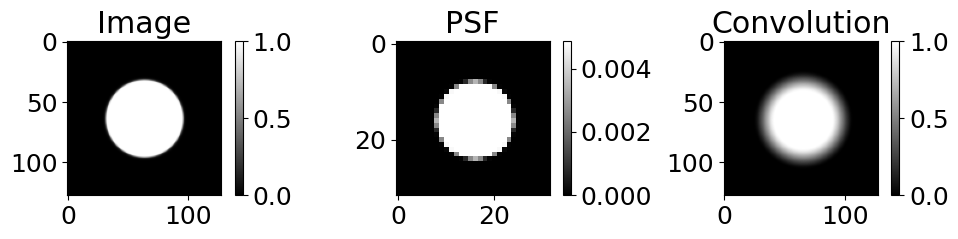

In [7]:
img = create_disk(128,128,radius=32,center=(64,64))
psf = create_disk(32,32,radius=8,center=(16,16))
psf /= jnp.sum(psf)
res = ex_convolve(img,psf)
fig, axs = plt.subplots(1,3,figsize=(12,2))
a0=axs[0].imshow(img,cmap="gray");plt.colorbar(a0,ax=axs[0])
axs[0].set_title("Image")
a1=axs[1].imshow(psf,cmap="gray");plt.colorbar(a1,ax=axs[1])
axs[1].set_title("PSF")
a2=axs[2].imshow(res,cmap="gray");plt.colorbar(a2,ax=axs[2]);
axs[2].set_title("Convolution");

No crash.... Let us now examine a jit version

In [22]:
MatplotlibClearMemory()

In [23]:
jax.clear_caches()
res1= jax.jit(ex_convolve)(img,psf) # crash

shape [159, 159]
fshape Traced<ShapedArray(uint16[2])>with<DynamicJaxprTrace(level=1/0)>


TracerIntegerConversionError: The __index__() method was called on traced array with shape uint16[]
The error occurred while tracing the function ex_convolve at /var/folders/x6/dxq9d35s0q59v_mxfkkptl3m0000gp/T/ipykernel_15478/2852530266.py:1 for jit. This value became a tracer due to JAX operations on these lines:

  operation a:i64[2] = convert_element_type[new_dtype=int64 weak_type=False] b
    from line /var/folders/x6/dxq9d35s0q59v_mxfkkptl3m0000gp/T/ipykernel_15478/2852530266.py:9 (ex_convolve)

  operation a:u16[] = convert_element_type[new_dtype=uint16 weak_type=False] b
    from line /var/folders/x6/dxq9d35s0q59v_mxfkkptl3m0000gp/T/ipykernel_15478/2852530266.py:9 (ex_convolve)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerIntegerConversionError

The problem comes from the `fshape` used by fft: it is traced while static is required as "Shape = Sequence[int]". The solution is to use pure Numpy function to compute fshape.

In [9]:
def ex_convolve_sol(in1,in2):

  axes = range(in1.ndim)

  s1 = in1.shape
  s2 = in2.shape
  shape = [s1[i] + s2[i] -1 for i in range(in1.ndim)]

  print("shape",shape)

  fshape = 2**np.ceil(np.log2(np.array(shape))).astype('uint16') #<-------- ok now

  print("fshape",fshape)

  sp1 = jnp.fft.fftn(in1, fshape, axes=axes)
  sp2 = jnp.fft.fftn(in2, fshape, axes=axes)
  conv = jnp.fft.irfftn(sp1 * sp2, fshape, axes=axes)
  conv = conv[tuple(map(slice, shape))]

  def _centered(arr, newshape):
    # Return the center newshape portion of the array.
    newshape = np.asarray(newshape)       #<-------- will be ok too
    currshape = np.array(arr.shape)       #<-------- idem
    startind = (currshape - newshape) // 2
    endind = startind + newshape
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

  return _centered(conv, s1)

In [10]:
jax.clear_caches()
res1= jax.jit(ex_convolve_sol)(img,psf)

shape [159, 159]
fshape [256 256]


In [11]:
jnp.all(res==res1)

Array(True, dtype=bool)

Let us make an example of jacobian computation of the convolved image wrt the center positon, this would be for instance an ingredient for likelihood fit or forward modeling bayesian inference...

In [12]:
def f(cxy,psf):
    img = create_disk(128,128,radius=32.,center=cxy)
    return  jax.scipy.signal.fftconvolve(img,psf)

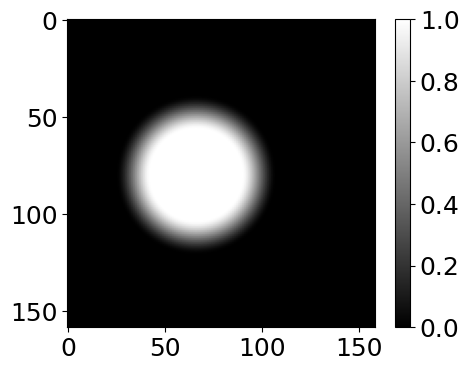

In [13]:
# Change the image center
psf = create_disk(32,32,radius=8.,center=(16,16))
psf /= jnp.sum(psf)
cxy=jnp.array([50.,64.])
tmp = f(cxy,psf)
plt.figure(figsize=(5,4))
plt.imshow(tmp,cmap="gray");plt.colorbar();

In [19]:
jax.clear_caches()
tst = jit(jacrev(partial(f,psf=psf)))(jnp.array([64.,64.]))

In [20]:
tst.shape

(159, 159, 2)

KeyboardInterrupt: 

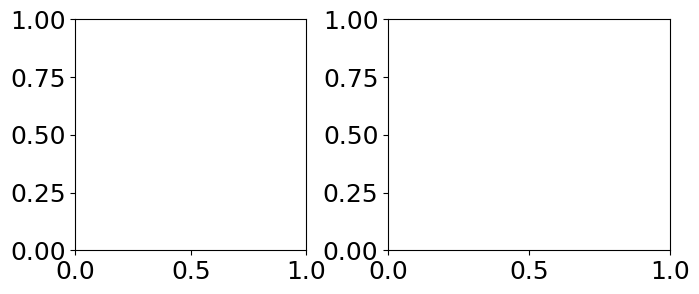

In [21]:
fig, axs = plt.subplots(1,2,figsize=(8,3))
im0=axs[0].imshow(tst[:,:,0]);plt.colorbar(im0,ax=axs[0])
im1=axs[1].imshow(tst[:,:,1]);plt.colorbar(im1,ax=axs[1])
for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

## Static (3): JIT in class

JAX is by essence a **functional programming language**, but user may be forced to use classes.

The following is a small part of [this nb](https://github.com/jecampagne/JaxTutos/blob/main/JAX_JIT_in_class.ipynb), which in turn has triggered the writing of the JAX documentation part [here](https://jax.readthedocs.io/en/latest/faq.html#how-to-use-jit-with-methods)

So, let us examine the following simple class.

In [123]:
class A():
    def __init__(self, x, v):
        self.a = 10.0
        self.x = x
        self.v = v

    def __repr__(self):
        return f"A(x={self.x}, v={self.v})"

    def step(self, dt):
        self.v += self.a * dt/2
        self.x = self.x + self.v * dt
        self.v += self.a * dt/2

objA = A(jnp.array([0., 0.5]), jnp.array([1., 1.5]))
print(objA)
objA.step(0.01)
print(objA)

A(x=[0.  0.5], v=[1.  1.5])
A(x=[0.0105 0.5155], v=[1.1 1.6])


### The problem: JIT a class method

In [124]:
jax.clear_caches()
class A():
    def __init__(self, x, v, a=10):
        self.a = a
        self.x = x
        self.v = v

    def __repr__(self):
        return f"A(x={self.x}, v={self.v})"

    @jit                  #<----------------
    def step(self, dt):
        self.v += self.a * dt/2
        self.x += self.v * dt
        self.v += self.a * dt/2


objA = A(jnp.array([0., 0.5]), jnp.array([1., 1.5]))
print(objA)
objA.step(0.01)
print(objA)

A(x=[0.  0.5], v=[1.  1.5])


TypeError: Cannot interpret value of type <class '__main__.A'> as an abstract array; it does not have a dtype attribute

JAX is not so friendly to point what is wrong.

The problem is that the first argument of the function is **self**, which has the type `A` and JAX does not know what it is.

There are different basic strategies that we can use in this case.

Below are the good practices.

*I do not use the "static_argnums/arg_names" to make "self" static.
What is behind? The problem is that `static_argnums` relies on the hash method of the object to determine if it has changed between two calls. You are forced to implement  `__hash__(self)` and `__eq__(self, other)` which becomes cumbersome.*

### 1st strategy: external function ('helper')

In [125]:
jax.clear_caches()
@jit                                          # JIT here
def _step(a,x,v,dt):
    v += a * dt/2
    x += v * dt
    v += a * dt/2
    return (x,v)

class A():
    def __init__(self, x, v, a=1.):
        self.a = a
        self.x = x
        self.v = v

    def __repr__(self):
        return f"A(p={self.x}, v={self.v})"

    def step(self, dt):                          # no JIT
        x,v = _step(self.a, self.x,self.v,dt)
        self.v = v
        self.x = x

objA = A(jnp.array([0., 0.5]), jnp.array([1., 1.5]))
objA.a = 10.  # a can be modified
print(objA)
objA.step(0.01)
print(objA)

A(p=[0.  0.5], v=[1.  1.5])
A(p=[0.0105 0.5155], v=[1.1 1.6])


- This is a simple method implementation, and we don't have to instruct JAX how to use the A class.
- Now it becomes a matter of taste to code a helper per function to use jit. But we can do file encapsulation so that at least the code of "A" is in the code of the definition of "A".
- Pb: how to manage the use-case with the function f needing for example another function (either member of A, or external to A)?

### 2d strategy: PyTree

In [126]:
from jax.tree_util import register_pytree_node_class

jax.clear_caches()
@register_pytree_node_class
class A():
    def __init__(self, x, v, a=10.):
        self.a = a
        self.x = x
        self.v = v

    def __repr__(self):
        return f"A(x={self.x}, v={self.v})"

    @jit                                  # JIT here & no static for self
    def step(self, dt):
        print("compile...")
        self.v += self.a * dt/2
        self.x += self.v * dt
        self.v += self.a * dt/2
        return self                       # should return self

    #### PyTree methods: tree_flatten, tree_unflatten
    def tree_flatten(self):
        traced = (self.x,self.v)           # dynamic/traced values
        aux_data = {"a":self.a}            # static values can be updated by user
        return (traced, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, traced):
        return cls(*traced, **aux_data) # should be the signature of __init__


In [127]:
objA = A(jnp.array([0., 0.5]), jnp.array([1., 1.5]))
print(objA)
objA = objA.step(0.01)
print(objA)

A(x=[0.  0.5], v=[1.  1.5])
compile...
A(x=[0.0105 0.5155], v=[1.1 1.6])


acc value: 9.81
compile...


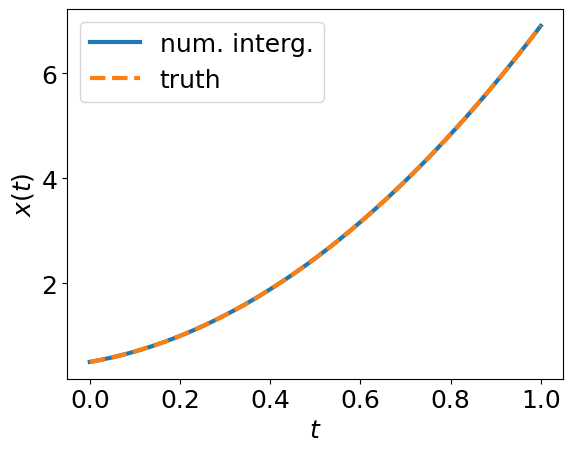

In [128]:
# Simple balistic exo
x0=0.5
v0=1.5
t0 = 0.
objA = A(x0, v0)
acc = 9.81
objA.a = acc      # update default
print("acc value:", objA.a)
info = [jnp.array([t0,x0])]
dt=0.01
T=t0
for i in range(100):
    objA = objA.step(dt)
    T += dt
    info.append(jnp.array([T,objA.x]))

info=jnp.array(info)

plt.plot(info[:,0],info[:,1],lw=3,label="num. interg.")
tvals=jnp.linspace(0.,1.)
xvals=0.5*acc*tvals**2 + tvals*v0 + x0 # true trajectory evolution
plt.plot(tvals,xvals,ls="--",lw=3,label="truth")
plt.xlabel("$t$")
plt.ylabel("$x(t)$")
plt.legend();

So PyTree is a key strcuture that allow you to make JAX vmap/jit.

But, there are some tricky points especially for initialisation

# PyTree initialisation phase

1st example: consequence of a stateful code called by __init__

In [129]:
@register_pytree_node_class
class State:
  def __init__(self, n: int):
    self.n = n
    jax.debug.print('n = {} # init before stateful', self.n)
    self.stateful()
    jax.debug.print('n = {} # init after stateful', self.n)

  def stateful(self):
    self.n += 100

  def tree_flatten(self):
    jax.debug.print('n = {} # flatten', self.n)
    return (self.n,), {}

  @classmethod
  def tree_unflatten(cls, aux_data, children):
    n, = children
    jax.debug.print('n = {} # unflatten', n)
    return cls(n)  # runs `__init__` and so call `stateful`

In [130]:
jax.clear_caches()
###

s = State(n=0)
print("After instantiation")

def do_nothing(i,x):
    jax.debug.print("call do_nothing i={}",i)
    return x

s_final = jax.lax.fori_loop(0,1,do_nothing,s)

print("n final: ",s_final.n)

n = 0 # init before stateful
n = 100 # init after stateful
After instantiation
n = 100 # flatten
n = 100 # flatten
n = 100 # flatten
n = 100 # flatten
call do_nothing i=0
n = 200 # flatten
n = 200 # init after stateful
n = 100 # unflatten
n = 100 # init before stateful
n = 200 # unflatten
n = 200 # init before stateful
n = 300 # init after stateful
n final:  300


You see that the `tree_unflatten` method is beeing called even before the `fori_loop` real activity and so `n_final` is not what one would have expected.

2rd example: call initialisation of variable in the __init__

In [131]:
class BaseObj():
    def __init__(self, *, sparams=None, **params):
          self._params = params      # Dictionary containing all traced parameters
          self._sparams = sparams  # Non-traced static parameters
          print('Init BaseObj')


    @property
    def sparams(self):
        """various parameters relevant for speed/accuracy trade-offs."""
        return self._sparams

    @property
    def params(self):
        """all parameters of the internal represention of this object."""
        return self._params

    def tree_flatten(self):
        jax.debug.print('tree_flatten')
        traced = (self.params,)                # traced
        aux_data = {"sparams": self.sparams}   # non traced
        return (traced, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, traced):
        """Recreates an instance of the class from flatten representation"""
        jax.debug.print('tree_unflatten')
        return cls(**(traced[0]), **aux_data)

@register_pytree_node_class
class Acrash(BaseObj):
    def __init__(self, a, sparams=None):
        super().__init__(a=a, sparams=sparams)
        print("a",a,type(a))
        self._m = a*2.     #<<< a function of a (crash if vmap)

    @property
    def a(self):
        return self.params["a"]

    def f(self,x):
        return self.a*x + self._m

In [132]:
a_list = Acrash(jnp.arange(4,dtype=jnp.float32))
print("try vmap...")
vmap(lambda t: t.f(1.))(a_list)

Init BaseObj
a [0. 1. 2. 3.] <class 'jaxlib.xla_extension.ArrayImpl'>
try vmap...
tree_flatten
tree_unflatten
Init BaseObj
a <object object at 0x7d59b0513fd0> <class 'object'>


TypeError: unsupported operand type(s) for *: 'object' and 'float'

A solution in this case : use `@property`

In [133]:
@register_pytree_node_class
class A(BaseObj):
    def __init__(self, a, sparams=None):
        super().__init__(a=a, sparams=sparams)
        print("a",a,type(a))

    @property
    def a(self):
        return self.params["a"]

    @property
    def _m(self):
         return 2. * self.a

    def f(self,x):
        jax.debug.print("x {}, a {}, _m {}",x,self.a,self._m)
        return self.a*x + self._m

a_list = A(jnp.arange(4,dtype=jnp.float32))
print("try vmap...")
res = vmap(lambda t: t.f(2.))(a_list)
print("res: ",res)

Init BaseObj
a [0. 1. 2. 3.] <class 'jaxlib.xla_extension.ArrayImpl'>
try vmap...
tree_flatten
tree_unflatten
Init BaseObj
a <object object at 0x7d59b0513120> <class 'object'>
tree_flatten
tree_unflatten
Init BaseObj
a Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0., 1., 2., 3.], dtype=float32)
  batch_dim = 0 <class 'jax._src.interpreters.batching.BatchTracer'>
x 2.0, a 0.0, _m 0.0
x 2.0, a 1.0, _m 2.0
x 2.0, a 2.0, _m 4.0
x 2.0, a 3.0, _m 6.0
res:  [ 0.  4.  8. 12.]


An other solution with an explicit `init`method

In [134]:
@register_pytree_node_class
class A_explicit(BaseObj):
    def __init__(self, a,  _m, sparams=None):
        super().__init__(a=a, _m=_m, sparams=sparams)
        print("a",a,type(a))

    # user initialisation
    @classmethod
    def init(cls, a,sparams=None):
        _m = 2. * a    # you can also call cls._build_m(a)
        return cls(a,_m,sparams)

    @property
    def a(self):
        return self.params["a"]

    @property
    def _m(self):
        return self.params["_m"]

    def f(self,x):
        jax.debug.print("x {}, a {}, _m {}",x,self.a,self._m)
        return self.a*x + self._m

In [135]:
a_list = A_explicit.init(jnp.arange(4,dtype=jnp.float32))
print("try vmap...")
res = vmap(lambda t: t.f(2.))(a_list)
print("res: ",res)

Init BaseObj
a [0. 1. 2. 3.] <class 'jaxlib.xla_extension.ArrayImpl'>
try vmap...
tree_flatten
tree_unflatten
Init BaseObj
a <object object at 0x7d59b0510af0> <class 'object'>
tree_flatten
tree_unflatten
Init BaseObj
a Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0., 1., 2., 3.], dtype=float32)
  batch_dim = 0 <class 'jax._src.interpreters.batching.BatchTracer'>
x 2.0, a 0.0, _m 0.0
x 2.0, a 1.0, _m 2.0
x 2.0, a 2.0, _m 4.0
x 2.0, a 3.0, _m 6.0
res:  [ 0.  4.  8. 12.]


Have a look at more advanced example in [JAX_PyTree_initialisation](https://github.com/jecampagne/JaxTutos/blob/main/JAX_PyTree_initialisation.ipynb)

The Tuto was "rather" short :) to investigate the whole JAX library.

1. See https://jax.readthedocs.io/en/latest/index.html
2. You can find same more material [here on my repo](https://github.com/jecampagne/JaxTutos) with concrete examples of some libraries, and also crash/solution investigation.  

Find/Try JAX as backend `TensorFlow` and `Keras` and the JAX thrid-party libraries.
   
Finaly, thanks for you attention, listen to W. Kabalan's talk for more on JIT with multi-devices.  